# AI Tools for Actuaries
## Chapter 5: CANN approach in Python
### Author: Michael Mayer and Mario Wuthrich
### Version April 2025

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.formula.api import glm
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(500)

### Define Poisson deviance loss function
We scale with $10^2$ for better visibility

In [2]:
def poisson_deviance(pred, obs):
    """Average Poisson deviance for claim counts."""
    dev_sum = 2 * (np.sum(pred) - np.sum(obs) + np.sum(np.log((obs / pred) ** obs)))
    return 100 * dev_sum / len(pred)

### Load data

In [3]:
# Load the data
df = pd.read_parquet("../../Data/freMTPL2freq.parquet")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678007 non-null  float64 
 1   Exposure    678007 non-null  float64 
 2   Area        678007 non-null  category
 3   VehPower    678007 non-null  int32   
 4   VehAge      678007 non-null  int32   
 5   DrivAge     678007 non-null  int32   
 6   BonusMalus  678007 non-null  int32   
 7   VehBrand    678007 non-null  category
 8   VehGas      678007 non-null  category
 9   Density     678007 non-null  int32   
 10  Region      678007 non-null  category
 11  ClaimTotal  678007 non-null  float64 
 12  ClaimNb     678007 non-null  float64 
 13  LearnTest   678007 non-null  object  
dtypes: category(4), float64(4), int32(5), object(1)
memory usage: 41.4+ MB
None


,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L


### Pre-process data for GLM

In [4]:
# Create GLM features
driv_age_lev = ["18-20", "21-25", "26-30", "31-40", "41-50", "51-70", "71+"]
driv_age_lev2 = ["31-40", *[lev for lev in driv_age_lev if lev != "31-40"]]

df = df.assign(
    AreaGLM=lambda x: x.Area.cat.codes + 1,  # Make Area code continuous
    VehPowerGLM=lambda x: pd.Categorical(x.VehPower.clip(0, 9)),  # Make categorical
    # Create age categories
    VehAgeGLM=lambda x: pd.cut(
        x.VehAge, bins=[-1, 5, 12, 101], labels=["0-5", "6-12", "12+"]
    ),
    DrivAgeGLM=lambda x: pd.Categorical(
        pd.cut(x.DrivAge, bins=[17, 20, 25, 30, 40, 50, 70, 101], labels=driv_age_lev),
        categories=driv_age_lev2,
    ),
    BonusMalusGLM=lambda x: x.BonusMalus.clip(0, 150),  # Censor bonus-malus level
    DensityGLM=lambda x: np.log(x.Density),  # Log-transform density
)

### Pre-process data for FNN - for entity embedding and standardization

In [5]:
def preprocess_continuous(var1, dat2):
    dat2[var1] = pd.to_numeric(dat2[var1])
    dat2[f"{var1}X"] = (dat2[var1] - dat2[var1].mean()) / dat2[var1].std()
    return dat2

def features_preprocess(dat2):
    dat2 = dat2.copy() 
    # Convert categorical variables to numeric first
    area_mapping = {cat: i for i, cat in enumerate(dat2["Area"].unique())}
    dat2["Area"] = pd.to_numeric(dat2["Area"].map(area_mapping))
    dat2 = preprocess_continuous("Area", dat2)
    dat2 = preprocess_continuous("VehPower", dat2)
    dat2["VehAge"] = dat2["VehAge"].clip(upper=20)
    dat2 = preprocess_continuous("VehAge", dat2)
    dat2["DrivAge"] = dat2["DrivAge"].clip(upper=90)
    dat2 = preprocess_continuous("DrivAge", dat2)
    dat2["BonusMalus"] = dat2["BonusMalus"].clip(upper=150)
    dat2 = preprocess_continuous("BonusMalus", dat2)
    vb_mapping = {cat: i for i, cat in enumerate(dat2["VehBrand"].unique())}
    dat2["VehBrandX"] = pd.to_numeric(dat2["VehBrand"].map(vb_mapping))
    gas_mapping = {cat: i for i, cat in enumerate(dat2["VehGas"].unique())}
    dat2["VehGasX"] = pd.to_numeric(dat2["VehGas"].map(gas_mapping))
    dat2["Density"] = np.log(dat2["Density"]).round(2)
    dat2 = preprocess_continuous("Density", dat2)
    reg_mapping = {cat: i for i, cat in enumerate(dat2["Region"].unique())}
    dat2["RegionX"] = pd.to_numeric(dat2["Region"].map(reg_mapping))
    return dat2

### Split into learning sample and test sample

In [6]:
# pre-process data
df = features_preprocess(df)

# Split data (this uses the same split and order as in Wuthrich-Merz, Springer 2023)
learn, test = (df[df.LearnTest == subset].copy() for subset in ("L", "T"))

print(f"Learning set size: {learn.shape[0]}")
print(f"Test set size: {test.shape[0]}")

Learning set size: 610206
Test set size: 67801


## GLM analysis

In [7]:
# Fit GLM
model = glm("ClaimNb ~ DrivAgeGLM + VehBrand + VehGas + DensityGLM + AreaGLM",
            data=learn,
            offset=np.log(learn['Exposure']),
            family=sm.families.Poisson())

glm_results = model.fit()

# Display model summary
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610206
Model:                            GLM   Df Residuals:                   610186
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -98513.
Date:                Tue, 15 Apr 2025   Deviance:                   1.5138e+05
Time:                        12:55:21   Pearson chi2:                 1.02e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.004052
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.2590    

### Calculate deviance losses

In [8]:
# Get predictions
learn['GLM'] = glm_results.predict(learn)*learn['Exposure']
test['GLM'] = glm_results.predict(test)*test['Exposure']

# Calculate in-sample and out-of-sample deviance
# Calculate in-sample and out-of-sample deviance
learn_deviance, test_deviance = (
    poisson_deviance(x.GLM, x.ClaimNb) for x in (learn, test)
)

print("Deviance Losses:")
print(f"Learning sample: {learn_deviance:.3f}")
print(f"Test sample: {test_deviance:.3f}")

Deviance Losses:
Learning sample: 24.807
Test sample: 25.027


## CANN step: using the GLM predictors as offsets in the FNN

### Define FNN of depth 3 with entity embeddings for categorical variables

In [9]:
# define FNN with entity embedding and three hidden layers
def create_fnn_emb(seed, q0, kk, bb, train):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    
    design_input = keras.layers.Input(shape=(q0[0],), dtype='float32')
    CANN_offset = keras.layers.Input(shape=(1,), dtype='float32')

    train_hidden = train[0].lower() == 'true'
    train_output = train[1].lower() == 'true'

    # Extract brand and region features (last two columns)
    brand_input = keras.layers.Lambda(lambda x: x[:, -2:-1])(design_input)
    region_input = keras.layers.Lambda(lambda x: x[:, -1:])(design_input)
    
    # Embedding layers
    brand_embed = keras.layers.Embedding(input_dim=kk[0], output_dim=bb[0], trainable=train_hidden)(brand_input)
    brand_embed = keras.layers.Flatten()(brand_embed)
    
    region_embed = keras.layers.Embedding(input_dim=kk[1], output_dim=bb[1], trainable=train_hidden)(region_input)
    region_embed = keras.layers.Flatten()(region_embed)
    
    # Continuous features (all except last two columns)
    continuous_features = keras.layers.Lambda(lambda x: x[:, :-2])(design_input)
    
    x = keras.layers.Concatenate()([continuous_features, brand_embed, region_embed])
    x = keras.layers.Dense(q0[1], activation='tanh', trainable=train_hidden)(x)
    x = keras.layers.Dense(q0[2], activation='tanh', trainable=train_hidden)(x)
    x = keras.layers.Dense(q0[3], activation='tanh', trainable=train_hidden)(x)
    x = keras.layers.Dense(1, activation='exponential', trainable=train_output)(x)
    
    # Multiply with the CANN prior/offset
    output = keras.layers.Multiply()([x, CANN_offset])
    
    model = keras.Model(inputs=[design_input, CANN_offset], outputs=output)
    return model

### Prepare the inputs

In [11]:
# Prepare features
features = ['AreaX', 'VehPowerX', 'VehAgeX', 'DrivAgeX', 'BonusMalusX',
           'VehGasX', 'DensityX', 'VehBrandX', 'RegionX']

q0 = len(features)

# Prepare matrices and ensure float32 dtype
X_learn = learn[features].astype('float32').values
X_test = test[features].astype('float32').values
# GLM priors for CANN
V_learn = learn['GLM'].astype('float32').values.reshape(-1, 1)
V_test = test['GLM'].astype('float32').values.reshape(-1, 1)
# Response
Y_learn = learn['ClaimNb'].astype('float32').values.reshape(-1, 1)
Y_test = test['ClaimNb'].astype('float32').values.reshape(-1, 1)

# Define network architecture
q00 = [q0, 20, 15, 10]
kk = [len(learn['VehBrandX'].unique()), len(learn['RegionX'].unique())]
bb  = [2,2]

seed = 100

# Create model
train = ['True', 'True']
model = create_fnn_emb(seed, q00, kk, bb, train)
# model.summary()


### Replicate GLM results within the FNN architecture

In [12]:

# Initialize to the GLM results
w0 = model.get_weights()
w0[-2] = np.zeros_like(w0[-2])
w0[-1] = np.zeros_like(w0[-1])
model.set_weights(w0)

test_hom = model.predict([X_test, V_test], batch_size=10**6)
learn_hom = model.predict([X_learn, V_learn], batch_size=10**6)

print("Poisson Deviance (Train, Test):", 
      round(poisson_deviance(learn_hom, Y_learn), 3),
      round(poisson_deviance(test_hom, Y_test), 3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Poisson Deviance (Train, Test): 24.807 25.027


### Train the CANN model

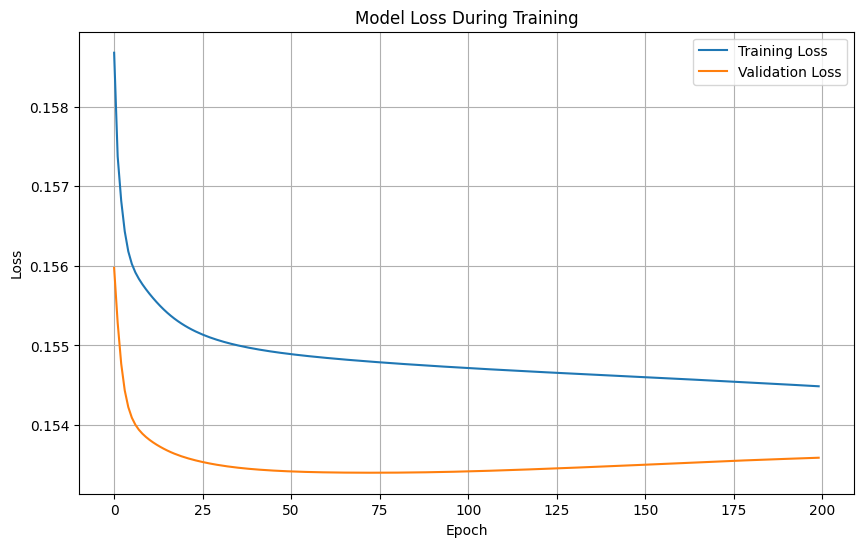

In [13]:
# Create checkpoint callback
import os
if not os.path.exists('./Networks'):
    os.makedirs('./Networks')

checkpoint_path = f'./Networks/CANN_{seed}.weights.h5'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                           monitor='val_loss',
                                           save_best_only=True,
                                           save_weights_only=True)

# Compile model
model.compile(loss='poisson', optimizer='nadam')

# Train model
history = model.fit([X_learn, V_learn], Y_learn,
                   validation_split=0.1,
                   batch_size=5000,
                   epochs=200,
                   verbose=0,
                   callbacks=[checkpoint])

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

### CANN results

In [14]:
# Load best weights and evaluate
model.load_weights(checkpoint_path)
w1 = model.get_weights()
learn_nn = model.predict([X_learn, V_learn], batch_size=10**6)
test_nn = model.predict([X_test, V_test], batch_size=10**6)

print("Poisson Deviance GLM (Train, Test):",
      round(learn_deviance, 3),
      round(test_deviance, 3))

print("Poisson Deviance CANN (Train, Test):",
      round(poisson_deviance(learn_nn, Y_learn), 3),
      round(poisson_deviance(test_nn, Y_test), 3))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Poisson Deviance GLM (Train, Test): 24.807 25.027
Poisson Deviance CANN (Train, Test): 23.742 23.827


### Plot the marginalized expected frequency for the Driver Age input variable

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


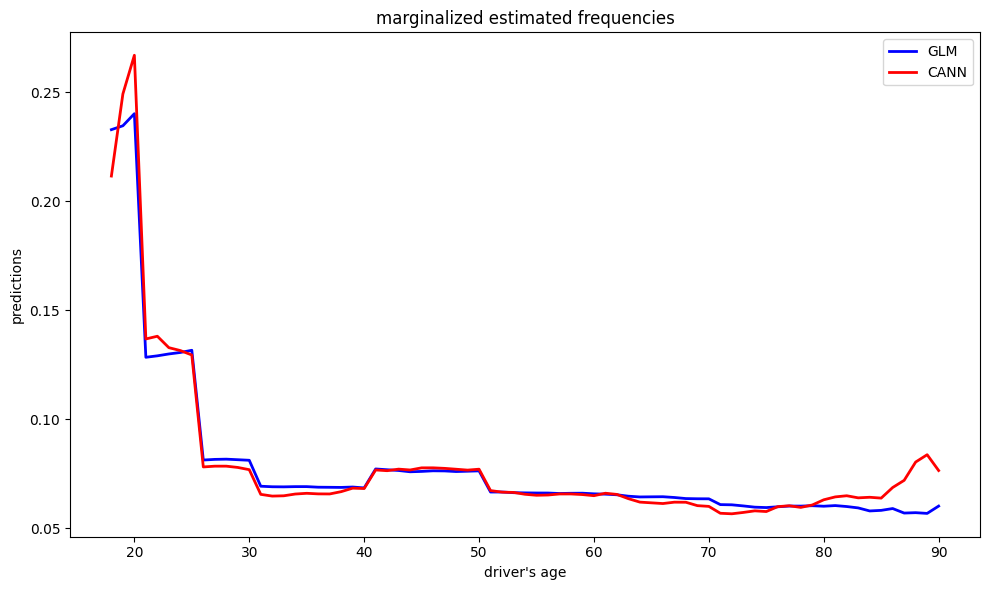

In [15]:

learn['CANN'] = model.predict([X_learn, V_learn], batch_size=10**6)
test['CANN'] = model.predict([X_test, V_test], batch_size=10**6)

# Create figure
plt.figure(figsize=(10, 6))

# Calculate aggregated frequencies
aggr = learn.groupby('DrivAge').agg({
    'GLM': 'sum',
    'CANN': 'sum',
    'Exposure': 'sum'
}).reset_index()


aggr['GLM'] = aggr['GLM'] / aggr['Exposure']
aggr['CANN'] = aggr['CANN'] / aggr['Exposure']

# Plot marginalized estimated frequencies
plt.plot(aggr['DrivAge'], aggr['GLM'], 'blue', linewidth=2, label='GLM')
plt.plot(aggr['DrivAge'], aggr['CANN'], 'red', linewidth=2, label='CANN')
plt.xlabel("driver's age")
plt.ylabel('predictions')
plt.title('marginalized estimated frequencies')
plt.legend()

plt.tight_layout()
plt.show()